In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')

In [55]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install prince 

Note: you may need to restart the kernel to use updated packages.


In [56]:
# pip install --upgrade patsy

# DATA ACQUISITION

In [25]:
df = pd.read_csv('Proveindustriales_Data_Cleaned_Kprototipe_csv.csv')

In [26]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'SUBCATEGORÍA',
       'PROVEEDOR', 'PRESUPUESTO', 'COMPAÑÍA_COMPRADORA', 'ESTADO',
       'PRODUCTO_O_SERVICIO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'PRECIO_UNITARIO_+_IVA', 'IVA', 'TOTAL_SIN_IVA',
       'TOTAL_+_IVA', 'FECHA_ÚLTIMO_MOVIMIENTO', 'DURACIÓN_ENTREGA',
       'DURACIÓN_APROBACIÓN'],
      dtype='object')

In [27]:
df.sample(2)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,SUBCATEGORÍA,PROVEEDOR,PRESUPUESTO,COMPAÑÍA_COMPRADORA,ESTADO,PRODUCTO_O_SERVICIO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,PRECIO_UNITARIO_+_IVA,IVA,TOTAL_SIN_IVA,TOTAL_+_IVA,FECHA_ÚLTIMO_MOVIMIENTO,DURACIÓN_ENTREGA,DURACIÓN_APROBACIÓN
7729,46734,922,"Aseo, Cafetería y Oficina",Elementos de aseo y limpieza,Proveedor 59,Presupuesto 496,Portal comprador 1,Finalizado Incompleto,"Bolsa para Basura Negra 65 X 90 Calibre 0,8 Pa...",1.000,1.000,15059.000,17920.000,2861,15059.000,17920.000,2021-04-22,0.000,0.000
19905,723,334,Alimentos y Bebidas,Bebidas,Proveedor 335,Presupuesto 711,Portal comprador 29,Orden en Proceso,PO_JUG_HIT_Naranja Piña PET 500ml,24.000,0.000,1282.000,1525.000,243,30756.000,36600.000,2018-10-10,3.242,0.000


## IRRELEVANT COLUMNS

In [28]:
cols_to_drop = ['FECHA_ÚLTIMO_MOVIMIENTO','DURACIÓN_ENTREGA', 'DURACIÓN_APROBACIÓN', 'PRECIO_UNITARIO_+_IVA', 'TOTAL_+_IVA', 'PRESUPUESTO', 'SUBCATEGORÍA', 'PRODUCTO_O_SERVICIO']

In [29]:
df.drop(cols_to_drop, inplace=True, axis=1)

## DF ORIGINAL

In [30]:
df.head(3)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,49561,2582,Eléctricos y Electrónicos,Proveedor 1,Portal comprador 1,Orden en Proceso,2.000,0.000,23364.000,4439,46728.000
1,49560,2581,Mercadeo y publicidad,Proveedor 2,Portal comprador 1,Recibido,1.000,1.000,1476972.000,280625,1476972.000
2,49559,2580,Alimentos y Bebidas,Proveedor 3,Portal comprador 1,Orden en Proceso,10.000,0.000,15500.000,0,155000.000


In [31]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA'],
      dtype='object')

## CHECK INSA()

In [32]:
df.isna().sum()

NÚMERO_PEDIDO          0
ORDEN_NÚMERO           0
CATEGORÍA              0
PROVEEDOR              0
COMPAÑÍA_COMPRADORA    0
ESTADO                 0
CANTIDAD_PEDIDA        0
CANTIDAD_RECIBIDA      0
PRECIO_UNITARIO        0
IVA                    0
TOTAL_SIN_IVA          0
dtype: int64

In [33]:
df.select_dtypes('object').nunique()

CATEGORÍA               36
PROVEEDOR              405
COMPAÑÍA_COMPRADORA     33
ESTADO                   9
dtype: int64

## DISTRIBUTION OF ALL "ESTADO"

In [34]:
df_ESTADO = pd.DataFrame(df['ESTADO'].value_counts()).reset_index()

In [35]:
df_ESTADO['Percentage'] = df_ESTADO['ESTADO'] / df['ESTADO'].value_counts().sum()

In [36]:
df_ESTADO.rename(columns = {'index':'ESTADO', 'ESTADO':'Total'}, inplace = True)


## CREATE THE DATAFRAME OF "ESTADO"

In [37]:
df_ESTADO.head(2)

,ESTADO,Total,Percentage
0,Recibido,14192,0.634
1,Orden en Proceso,4872,0.218


### Sort values by TOTAL

In [38]:
df_ESTADO = df_ESTADO.sort_values('Total', ascending = True).reset_index(drop = True)

In [39]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA'],
      dtype='object')

## GROUP BY ESTADO

In [40]:
# The dataframe
df_ESTADO = df.groupby('ESTADO').agg({
    'ESTADO': 'count',
    'CANTIDAD_PEDIDA': 'sum',
    'CANTIDAD_RECIBIDA': 'sum',
    'PRECIO_UNITARIO': 'mean',
    'IVA': 'sum',
    'TOTAL_SIN_IVA': 'sum'
    }
).rename(columns = {'ESTADO': 'Total'}).reset_index().sort_values('Total', ascending = True)

In [41]:
df_ESTADO.sort_values(by='Total', ascending=False).head(10)

,ESTADO,Total,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
7,Recibido,14192,1084344.230,1084338.460,83543.011,191472209,7303375098.000
5,Orden en Proceso,4872,3019314.700,0.000,48825.617,28402906,1717373030.000
0,Cancelado,1139,91049.500,14.000,101382.776,18167621,801035410.000
4,Orden Rechazada,1012,18634.200,0.000,55732.784,9715160,339305639.000
2,Finalizado Incompleto,936,26888.000,19929.600,36479.253,4938395,355467416.000
8,Recibido Parcial,163,9480.000,4639.000,121682.368,3576354,122641077.000
6,Pendiente por Aprobar,51,1086.000,0.000,146278.647,898313,19419690.000
3,Orden Confirmada,15,150113.000,0.000,111248.267,317060,6545071.000
1,Enviado,12,3138.000,0.000,15765.417,13335,28337244.000


## CROSS TAB "CATEGORY"

In [42]:
order_ESTADO = df_ESTADO['ESTADO'].to_list()

In [43]:
order_ESTADO.append('All')

In [44]:
(pd.crosstab(df['ESTADO'], df['CATEGORÍA'], margins = True).reindex(order_ESTADO, axis = 0).reset_index()).sort_values(by='All', ascending='True').head(7)

CATEGORÍA,ESTADO,Agroindustrial,Alimentos y Bebidas,Almacenamiento y empaques,"Aseo, Cafetería y Oficina",Compras Sostenibles,Construcción y Mantenimiento,Cuidado personal y Belleza,Deporte y recreación,Dotación y elementos de protección personal,...,Salud y Medicina,Servicios Profesionales,Servicios Públicos,Tecnología e información,Textiles,Vehículos y repuestos,"Viajes, Eventos y Entretenimiento",Vigilancia y seguridad,Vigilancia y seguridad industrial,All
0,Enviado,0,5,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
1,Orden Confirmada,0,0,2,6,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,15
2,Pendiente por Aprobar,0,13,4,16,0,1,0,0,6,...,0,0,0,2,0,5,0,0,0,51
3,Recibido Parcial,0,6,1,3,1,1,0,0,112,...,1,5,0,0,1,1,0,2,17,163
4,Finalizado Incompleto,0,305,25,443,3,3,0,0,17,...,0,1,0,1,3,7,0,0,52,936
5,Orden Rechazada,0,271,16,266,3,6,0,0,288,...,19,11,0,8,6,19,0,0,18,1012
6,Cancelado,0,383,63,242,0,7,0,0,186,...,0,8,0,20,6,38,0,4,11,1139


In [45]:
df_CATEGORIA = pd.crosstab(df['ESTADO'], df['CATEGORÍA'], margins = True).reindex(order_ESTADO, axis = 0).reset_index()

In [46]:
# Remove index name
df_CATEGORIA.columns.name = None
df_CATEGORIA.head(3)

,ESTADO,Agroindustrial,Alimentos y Bebidas,Almacenamiento y empaques,"Aseo, Cafetería y Oficina",Compras Sostenibles,Construcción y Mantenimiento,Cuidado personal y Belleza,Deporte y recreación,Dotación y elementos de protección personal,...,Salud y Medicina,Servicios Profesionales,Servicios Públicos,Tecnología e información,Textiles,Vehículos y repuestos,"Viajes, Eventos y Entretenimiento",Vigilancia y seguridad,Vigilancia y seguridad industrial,All
0,Enviado,0,5,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
1,Orden Confirmada,0,0,2,6,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,15
2,Pendiente por Aprobar,0,13,4,16,0,1,0,0,6,...,0,0,0,2,0,5,0,0,0,51


## GET POSITION OF CATEGORICAL COLS

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22392 entries, 0 to 22391
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NÚMERO_PEDIDO        22392 non-null  int64  
 1   ORDEN_NÚMERO         22392 non-null  int64  
 2   CATEGORÍA            22392 non-null  object 
 3   PROVEEDOR            22392 non-null  object 
 4   COMPAÑÍA_COMPRADORA  22392 non-null  object 
 5   ESTADO               22392 non-null  object 
 6   CANTIDAD_PEDIDA      22392 non-null  float64
 7   CANTIDAD_RECIBIDA    22392 non-null  float64
 8   PRECIO_UNITARIO      22392 non-null  float64
 9   IVA                  22392 non-null  int64  
 10  TOTAL_SIN_IVA        22392 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.9+ MB


In [48]:
[df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

[2, 3, 4, 5]

In [49]:
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

In [50]:
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['CATEGORÍA', 'PROVEEDOR', 'COMPAÑÍA_COMPRADORA', 'ESTADO']
Categorical columns position  : [2, 3, 4, 5]


## CONVERT DF TO MATRIX WITH NUMPY

In [51]:
dfMatrix = df.to_numpy()
dfMatrix

array([[49561, 2582, 'Eléctricos y Electrónicos', ..., 23364.0, 4439,
        46728.0],
       [49560, 2581, 'Mercadeo y publicidad', ..., 1476972.0, 280625,
        1476972.0],
       [49559, 2580, 'Alimentos y Bebidas', ..., 15500.0, 0, 155000.0],
       ...,
       [2, 2, 'Moda y accesorios', ..., 29412.0, 5588, 88235.0],
       [1, 1, 'Moda y accesorios', ..., 29412.0, 5588, 117647.0],
       [1, 1, 'Aseo, Cafetería y Oficina', ..., 33613.0, 6387, 168067.0]],
      dtype=object)

## OPTIMAL K USING ELBOW METHOD

In [36]:
cost = []
for cluster in range(2, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


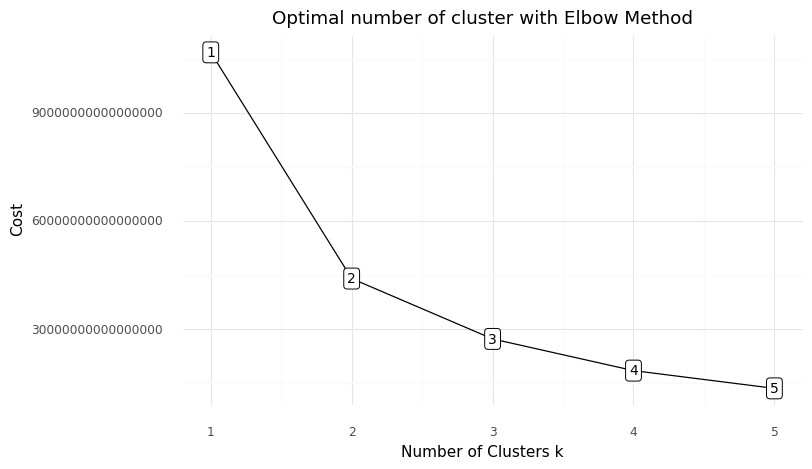

<ggplot: (109791805949)>

In [38]:
#Converting the results into a dataframe and plotting them

df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# Data viz

plotnine.options.figure_size = (8, 4.8)
(
     ggplot(data = df_cost)+
     geom_line(aes(x = 'Cluster',
                   y = 'Cost'))+
     geom_point(aes(x = 'Cluster',
                    y = 'Cost'))+
     geom_label(aes(x = 'Cluster',
                    y = 'Cost',
                    label = 'Cluster'),
                size = 10,
                nudge_y = 1000) +
     labs(title = 'Optimal number of cluster with Elbow Method')+
     xlab('Number of Clusters k')+
     ylab('Cost')+
     theme_minimal()
)

## FTI MODEL WITH K CLUSTER

In [52]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

### CENTROIDS

In [53]:
# Cluster centorid
kprototype.cluster_centroids_

array([['35110.93985601216', '707.6979832759469', '196.3368345034208',
        '49.02262934311139', '60042.934400572376', '9631.38671019094',
        '407609.97088941553', 'Alimentos y Bebidas', 'Proveedor 301',
        'Portal comprador 1', 'Recibido'],
       ['47255.5', '1216.5', '8.5', '1.4551915228366852e-11',
        '31731777.0', '3158067.5', '270475610.0',
        'Construcción y Mantenimiento', 'Proveedor 20',
        'Portal comprador 1', 'Cancelado'],
       ['42434.88888888889', '1126.6666666666667', '494.4444444444412',
        '467.7037037037048', '9351504.037037037', '1325871.0',
        '38413580.59259259', 'Construcción y Mantenimiento',
        'Proveedor 301', 'Portal comprador 1', 'Recibido']], dtype='<U32')

N_ITER

In [54]:

# Check the iteration of the clusters created
kprototype.n_iter_

15

### COST_

In [55]:

# Check the cost of the clusters created
kprototype.cost_

4.40620859834869e+16

## ADD THE CLUSTER TO THE DF

In [56]:
df['Cluster Labels'] = kprototype.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})

In [57]:
len(kprototype.labels_)

22392

In [60]:
df.head(4)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA,Cluster Labels,Segment
0,49561,2582,Eléctricos y Electrónicos,Proveedor 1,Portal comprador 1,Orden en Proceso,2.000,0.000,23364.000,4439,46728.000,0,First
1,49560,2581,Mercadeo y publicidad,Proveedor 2,Portal comprador 1,Recibido,1.000,1.000,1476972.000,280625,1476972.000,0,First
2,49559,2580,Alimentos y Bebidas,Proveedor 3,Portal comprador 1,Orden en Proceso,10.000,0.000,15500.000,0,155000.000,0,First
3,49558,1892,Alimentos y Bebidas,Proveedor 4,Portal comprador 2,Orden en Proceso,50.000,0.000,22000.000,0,1100000.000,0,First


In [61]:
#df.to_csv("Kprototype_clusters_3_Estado.csv")

## ORDER CLUSTER

In [48]:
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
df['Segment'] = df['Segment'].cat.reorder_categories(list(df["Segment"].unique()))

In [49]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA', 'Cluster Labels', 'Segment'],
      dtype='object')

## CLUSTER INTERPRETATION

In [50]:
# Cluster interpretation
df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df.groupby('Segment').agg(
    {
        'Total':'count',
        'COMPAÑÍA_COMPRADORA': lambda x: x.value_counts().index[0],
        'CATEGORÍA':lambda x: x.value_counts().index[0],
        'ESTADO':lambda x: x.value_counts().index[0],
        'PROVEEDOR':lambda x: x.value_counts().index[0],
        'CANTIDAD_PEDIDA': 'sum',
        'CANTIDAD_RECIBIDA': 'sum',
        'PRECIO_UNITARIO': 'mean',
        'IVA': 'sum',
        'TOTAL_SIN_IVA': 'sum'

    }
).reset_index()

,Segment,Total,COMPAÑÍA_COMPRADORA,CATEGORÍA,ESTADO,PROVEEDOR,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,First,22363,Portal comprador 1,Alimentos y Bebidas,Recibido,Proveedor 301,4390680.630,1096293.060,60042.934,215386701,9115381779.000
1,Third,27,Portal comprador 1,Construcción y Mantenimiento,Recibido,Proveedor 301,13350.000,12628.000,9351504.037,35798517,1037166676.000
2,Second,2,Portal comprador 1,Construcción y Mantenimiento,Orden en Proceso,Proveedor 20,17.000,0.000,31731777.000,6316135,540951220.000


In [51]:
df.groupby('Segment')['Segment'].count()

Segment
First     22363
Third        27
Second        2
Name: Segment, dtype: int64

# FAMD

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (0.19% inertia)', ylabel='Component 1 (0.17% inertia)'>

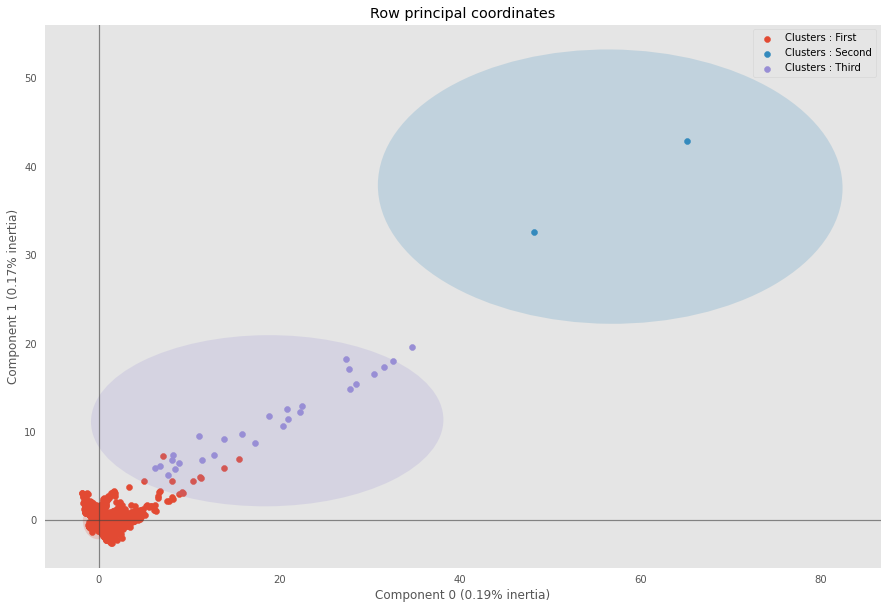

In [19]:
from prince import FAMD

X=pd.read_csv("Kprototype_clusters_3.csv")

famd = FAMD(n_components =2, n_iter = 3, random_state = 101)

famd.fit(X)
famd.transform(X)
famd.plot_row_coordinates(X,figsize=(15, 10),color_labels=['Clusters : {}'.format(t) for t in X['Segment']] )

#X.get_figure().savefig('images/famd_row_coordinates.svg')

